**Image Classifier with a Convolution Neural Network (CNN)**

This classifier will classify a X-Ray dataset (https://www.kaggle.com/datasets/andrewmvd/covid19-xray-severity-scoring) using a deep convolutional neural network based on prognostic scoring using the BRIXIA scoring system.

We will use PyTorch (https://pytorch.org/) as our deep learning framework. 

In [4]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os

from imutils import build_montages
import cv2

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

import seaborn as sn
import pandas as pd

# Set up CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == torch.device("cpu"):
  print('Set the runtime to GPU!')
else:
  print(f"Device: {device}")

Device: cuda


In [2]:
# Add label to save files
save_lab = '-net4'

##### change path to x-ray files location !!!!! ######
#path = "/pine/scr/k/a/kathlyne/comp562/final_project/" 
path = r"C:\Users\annavp\Documents\jupyter_books\ML_final\data"
######################################################

Define dataset and CNN classes:

In [52]:
### Define custom dataset ###
class XRayDataset(Dataset):
    def __init__(self,image_paths,image_labels,transform=False):
        self.image_paths = image_paths
        self.image_labels = image_labels
        self.transform = transform
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self,idx):
        image_filepath = self.image_paths[idx]
#         image_filepath = self.image_paths.iloc[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        label = (self.image_labels[idx]).astype(int)
#         label = (self.image_labels.iloc[idx]).astype(int)
        if self.transform is not None:
            image = self.transform(image)
        return image, label
    
## CNN architecture
class simple_cnn(torch.nn.Module):
    def __init__(self,input_channels,n_filters,filt_size,input_size,n_classes):
        super().__init__()

        # inputs
        self.input_channels = input_channels # number of channels in the input image
        self.n_filters = n_filters # list of number of filters in each layer
        self.filt_size = filt_size # list of filter sizes
        self.input_size = input_size  # size of the input image
        self.n_classes = n_classes;

        # avg pooling
        self.pool = torch.nn.AvgPool2d(2,2) 

        # conv layers
        self.conv0 = torch.nn.Conv2d(in_channels = input_channels, out_channels = n_filters[0], kernel_size = filt_size[0], padding = 0, stride = 2)
        self.conv1 = torch.nn.Conv2d(in_channels = n_filters[0], out_channels = n_filters[1], kernel_size = filt_size[1], padding = 0, stride = 2)
        self.conv2 = torch.nn.Conv2d(in_channels = n_filters[1],out_channels = n_filters[2], kernel_size = filt_size[2], padding = 0, stride = 2)

        # linear layer - applies a linear transformation
        self.fc0 = torch.nn.Linear(in_features = 288, out_features = 64)
        self.fc1 = torch.nn.Linear(in_features = 64, out_features = 2) 

        # batch normalization
        self.batchnorm1 = torch.nn.BatchNorm2d(n_filters[0])
        self.batchnorm2 = torch.nn.BatchNorm2d(n_filters[1])
        self.batchnorm3 = torch.nn.BatchNorm2d(n_filters[2])

        # dropout
        self.drop2d1 = torch.nn.Dropout2d(0.2)
        self.drop2d2 = torch.nn.Dropout2d(0.3)

    def forward(self,x):
        x = self.conv0(x)
        x = self.batchnorm1(x)
        x = self.drop2d1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv1(x)
        x = self.batchnorm2(x)
        x = self.drop2d2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.batchnorm3(x)
        x = self.drop2d2(x)
        x = F.relu(x)
        x = self.pool(x)

        x = torch.flatten(x, 1)

        x = self.fc0(x)
        x = F.relu(x)
        x = self.fc1(x)
        return x

def reset_weights(m):
    '''
    Try resetting model weights to avoid
    weight leakage.
    '''
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()
            


<!--bibtex
@article{BS-Net2021,
  title = {BS-Net: learning COVID-19 pneumonia severity on a large Chest X-Ray dataset},
  journal = {Medical Image Analysis},
  pages = {102046},
  year = {2021},
  issn = {1361-8415},
  doi = {https://doi.org/10.1016/j.media.2021.102046},
  url = {https://www.sciencedirect.com/science/article/pii/S136184152100092X},
  author = {Alberto Signoroni and Mattia Savardi and Sergio Benini and Nicola Adami and Riccardo Leonardi and Paolo Gibellini and Filippo Vaccher and Marco Ravanelli and Andrea Borghesi and Roberto Maroldi and Davide Farina},
}

@article{borghesi2020covid,
  title={COVID-19 outbreak in Italy: experimental chest X-ray scoring system for quantifying and monitoring disease progression},
  author={Borghesi, Andrea and Maroldi, Roberto},
  journal={La radiologia medica},
  volume={125},
  pages={509-513},
  year={2020},
  publisher={Springer}
}
@article{borghesi_et_al_2020, 
    title={Chest X-ray severity index as a predictor of in-hospital mortality in coronavirus disease 2019: A study of 302 patients from Italy}, 
    volume={96}, 
    DOI={10.1016/j.ijid.2020.05.021}, 
    journal={International Journal of Infectious Diseases}, 
    author={Borghesi, Andrea and Zigliani, Angelo and Golemi, Salvatore and Carapella, Nicola and Maculotti, Patrizia and Farina, Davide and Maroldi, Roberto}, 
    year={2020}, 
    pages={291–293}} 
-->
The dataset (https://www.kaggle.com/datasets/andrewmvd/covid19-xray-severity-scoring) will be loaded from Kaggle. Refer to these papers for extensive discussion of the methods relating to this dataset:
([Signoroni et al., 2021](#cite-BS-Net2021)) and ([Borghesi & Maroldi, 2020](#cite-borghesi2020covid)).

The Global Brixia Score labels will be binarized based on a cutoff value of 8 presented in this paper ([Borghesi et al., 2020](#cite-borghesi_et_al_2020)). A binary classification will be done. 

The segmented x-ray images will be used for ease of classification. 

In [38]:
cols = ["Filename","BrixiaScoreGlobal","ConsensusTestset"]
cutoff = 8 # optimal cutoff based on literature (add citation)

# Get list of file paths to images
metadata = pd.read_csv(os.path.join(path,"metadata.csv"),sep=";",usecols=cols)
file_list = metadata.Filename.copy()

for i in range(len(file_list)):
    tmp = str(os.path.splitext(file_list[i])[0])
    file_list[i] = os.path.join(path,"segmented_png",(tmp+".png"))

# Define image labels based on cutoff value
labels = (metadata.BrixiaScoreGlobal >= cutoff)
  # 0 = low Brixia score (< 8)
  # 1 = high Brixia score (>= 8)

# Split into training and test sets
full_training_files = file_list[(metadata.ConsensusTestset == 0)].to_numpy()
full_training_labels = labels[metadata.ConsensusTestset == 0].to_numpy()
test_files = file_list[metadata.ConsensusTestset == 1].to_numpy()
test_labels = labels[metadata.ConsensusTestset == 1].to_numpy()

K-fold cross-validation with 80/20 split will be used to reduce generalization error for the model. Stratification will be used to ensure class balance in each fold.

In [45]:
skf = StratifiedKFold(n_splits=5, random_state=6, shuffle=True)
print(skf)
# class balance for full training set:
print(f"Percent Pos: {sum(full_training_labels) / len(full_training_labels)}")
print(f"Percent Neg: {(len(full_training_labels) - sum(full_training_labels)) / len(full_training_labels)}")

kfold_indices = [(train_index, val_index) for train_index, val_index in skf.split(full_training_files, full_training_labels)]

# class balance for each fold:
for train_index, val_index in kfold_indices:
    train_files, validation_files = full_training_files[train_index], full_training_files[val_index]
    train_labels, validation_labels = full_training_labels[train_index], full_training_labels[val_index]
    print(len(train_files),len(validation_files))
    numpos = sum(train_labels)
    print(f"Train Percent Pos: {sum(train_labels) / len(train_labels)}")
    print(f"Val Percent Pos: {sum(validation_labels) / len(validation_labels)}")
    print(f"Train Percent Neg: {(len(train_labels)-sum(train_labels)) / len(train_labels)}")
    print(f"Val Percent Neg: {(len(validation_labels)-sum(validation_labels)) / len(validation_labels)}")
    


StratifiedKFold(n_splits=5, random_state=6, shuffle=True)
Percent Pos: 0.5685368536853685
Percent Neg: 0.43146314631463145
3636 909
Train Percent Pos: 0.5687568756875687
Val Percent Pos: 0.5676567656765676
Train Percent Neg: 0.4312431243124312
Val Percent Neg: 0.43234323432343236
3636 909
Train Percent Pos: 0.5684818481848185
Val Percent Pos: 0.5687568756875687
Train Percent Neg: 0.4315181518151815
Val Percent Neg: 0.4312431243124312
3636 909
Train Percent Pos: 0.5684818481848185
Val Percent Pos: 0.5687568756875687
Train Percent Neg: 0.4315181518151815
Val Percent Neg: 0.4312431243124312
3636 909
Train Percent Pos: 0.5684818481848185
Val Percent Pos: 0.5687568756875687
Train Percent Neg: 0.4315181518151815
Val Percent Neg: 0.4312431243124312
3636 909
Train Percent Pos: 0.5684818481848185
Val Percent Pos: 0.5687568756875687
Train Percent Neg: 0.4315181518151815
Val Percent Neg: 0.4312431243124312


Model Training

In [58]:
def epoch(phase, loader, model, optimizer, loss_fn, verbose=True):
    running_loss_epoch = 0.0
    running_accuracy_epoch = []
    running_loss = 0.0
    running_accuracy = []
    
    ### Model calculations
    if phase == 'train':
        model.train()
    else:
        model.eval()   
    
    enable_grad = True if phase == 'train' else False
    with torch.set_grad_enabled(enable_grad):
        for idx_batch, data in enumerate(loader):
            ### Get data, send it to the GPU
            img, lab = data
            img = img.to(device)
            lab = lab.to(device).type(torch.cuda.LongTensor)

            ### Model calculations
            if phase == 'train':
                # zero the gradients out
                optimizer.zero_grad()

            # get the predictions of the model and compute the loss
            out = model(img)

            # calc loss
            loss = loss_fn(out, lab)

            if phase == 'train':
                # calculate the gradient and take a step with the model
                loss.backward()
                optimizer.step()

            # add the loss for this batch to the running loss
            running_loss += loss.item()
            running_loss_epoch += loss.item()

            # running accuracy calculation
            running_accuracy.append(((sum(torch.argmax(out,1) == lab) / loader.batch_size)).item())
            running_accuracy_epoch.append(((sum(torch.argmax(out,1) == lab) / loader.batch_size)).item())
            if (idx_batch+1) % 20 == 0:
                if verbose:
                    print(f'[{idx_batch + 1:5d}] loss: {running_loss / 20:.3f}, accuracy: {np.mean(running_accuracy):.3f}')
                running_loss = 0.0 # reset this value, else your loss will seem to be going up every time
                running_accuracy = []
            
    return running_loss_epoch, running_accuracy_epoch, running_loss, running_accuracy

def train_model(training_params, loader_dict, n_epochs, save_kwargs):
    losses, accuracies, val_losses, val_accuracies = [], [], [], []

    for idx_epoch in range(n_epochs):  # loop over the dataset multiple times
        print(f"Training Epoch [{idx_epoch+1}/{n_epochs}]")
        phase = 'train'
        loader = loader_dict[phase]
        running_loss_epoch, running_accuracy_epoch, running_loss, running_accuracy = epoch(phase, loader, **training_params)
        losses.append(running_loss_epoch / len(loader))
        accuracies.append(np.mean(running_accuracy_epoch))

        # calculate loss, accuracy on validation set
        phase = 'val'
        loader = loader_dict[phase]
        running_loss_epoch, running_accuracy_epoch, running_loss, running_accuracy = epoch(phase, loader, **training_params)
        val_losses.append(running_loss_epoch / len(loader))
        val_accuracies.append(np.mean(running_accuracy_epoch))
        print(f'--- Validation loss: {val_losses[-1]:.3f}')
        print(f'--- Validation accuracy: {val_accuracies[-1]:.3f}')

        # Save the model at each epoch
        base_path, save_lab = save_kwargs['base_path'], save_kwargs['save_lab']
        idx_kfold = save_kwargs.get('idx_kfold', None)
        base_model_save_path = f"{base_path}/models"
        os.makedirs(base_model_save_path, exist_ok=True)
        if idx_kfold is not None:
            model_save_path = f"{base_model_save_path}/covid_xray_classifier{save_lab}kfold{idx_kfold+1}epoch{idx_epoch+1}.pth"
        else:
            model_save_path = f"{base_model_save_path}/covid_xray_classifier{save_lab}epoch{idx_epoch+1}.pth" 
        torch.save(model.state_dict(), model_save_path)
        
    return losses, accuracies, val_losses, val_accuracies
        
# Model save kwargs
save_kwargs = dict(
    base_path=path,
    save_lab=save_lab,
)

# Setup transform composition object
transform = transforms.Compose(
    [transforms.ToTensor(), # convert to tensor
     transforms.Normalize((0.5,), (0.5,))] # normalize
)

# Shared dataloader parameters
loader_params = dict(
    batch_size=32, # randomly-chosen - ideally, needs a hyperparameter search
    num_workers=0,
)

# Create model
image_size = 512 # pixel dimensions of image
model_params = dict(
    n_filters = [8,16,32],
    filt_size = [16,16,16],
    input_size = image_size,
    n_classes = 2,
    input_channels = 1, # grayscale image
)
model = simple_cnn(**model_params).to(device)

### Cost function ###
# Cross Entropy Loss
loss_fn = torch.nn.CrossEntropyLoss()

### Optimizer ###
# Stochastic Gradient Descent
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)

training_params = dict(
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
)

n_epochs = 2

## Actually train the model in this loop ##
results = {}
for idx_kfold, (train_index, val_index) in enumerate(kfold_indices):
    print(f"{'*'*100}\nTraining model [{idx_kfold+1}/{len(kfold_indices)}]\n{'*'*100}\n")
    
    # Reset model params
    reset_weights(model)
    
    # Split into kth fold
    train_files, validation_files = full_training_files[train_index], full_training_files[val_index]
    train_labels, validation_labels = full_training_labels[train_index], full_training_labels[val_index]
    print(f"Number of images in the training set: {len(train_files)}")
    print(f"Number of images in the validation set: {len(validation_files)}")
    print(f"Number of images in the test set: {len(test_files)}")

    ### Create datasets ###
    train_set = XRayDataset(train_files, train_labels, transform)
    validation_set = XRayDataset(validation_files, validation_labels, transform)
    test_set = XRayDataset(test_files, test_labels, transform)

    # Load the datasets using Pytorch DataLoader
    loader_dict = dict(
        train = torch.utils.data.DataLoader(train_set, **loader_params, shuffle=True),
        val = torch.utils.data.DataLoader(validation_set, **loader_params),
        test = torch.utils.data.DataLoader(test_set, **loader_params),
    )
    
    # Train model
    save_kwargs['idx_kfold'] = idx_kfold
    losses, accuracies, val_losses, val_accuracies = train_model(training_params, loader_dict, n_epochs, save_kwargs)
    
    results[f"{idx_kfold=}"] = dict(
        losses=losses,
        accuracies=accuracies,
        val_losses=val_losses, 
        val_accuracies=val_accuracies,
    )
    
    if idx_kfold == 1:
        break
    
    

****************************************************************************************************
Training model [1/5]
****************************************************************************************************

Reset trainable parameters of layer = Conv2d(1, 8, kernel_size=(16, 16), stride=(2, 2))
Reset trainable parameters of layer = Conv2d(8, 16, kernel_size=(16, 16), stride=(2, 2))
Reset trainable parameters of layer = Conv2d(16, 32, kernel_size=(16, 16), stride=(2, 2))
Reset trainable parameters of layer = Linear(in_features=288, out_features=64, bias=True)
Reset trainable parameters of layer = Linear(in_features=64, out_features=2, bias=True)
Reset trainable parameters of layer = BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, trac

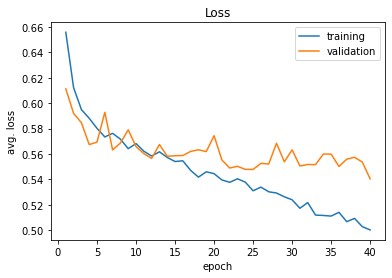

In [11]:
# Plot losses
plt.plot(range(1,np.shape(losses)[0]+1),losses,label='training')
plt.plot(range(1,np.shape(val_losses)[0]+1),val_losses,label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('avg. loss')
plt.title('Loss')
plt.savefig(path+'/loss'+save_lab+'.png')

In [65]:
losses = np.array([ results[f'idx_kfold={k}']['losses'] for k in range(2) ] )
losses

array([[0.65377123, 0.61447658],
       [0.65433835, 0.60738764]])

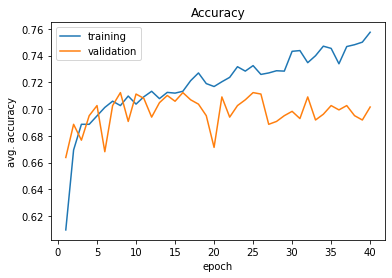

In [12]:
# Plot accuracies
plt.plot(range(1,np.shape(accuracies)[0]+1),accuracies,label='training')
plt.plot(range(1,np.shape(val_accuracies)[0]+1),val_accuracies,label='validation')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('avg. accuracy')
plt.title('Accuracy')
plt.savefig(path+'/accuracy'+save_lab+'.png')

In [13]:
torch.cuda.empty_cache()